# Lab 3 A: Neural Network for Customer Churn Prediction

**Dataset:** `churn.csv`  
**Goal:** Predict whether a bank customer will leave the bank (`Exited = 1`) using a neural network classifier.

You will implement the following pieces:

1. `prepare_data(df)` – preprocessing, encoding, scaling, train/validation split  
2. `ChurnDataset` – custom PyTorch Dataset  
3. `build_model(input_dim)` – neural network classifier  
4. `train_one_epoch(model, train_loader, criterion, optimizer)` – train loop for one epoch  
5. `evaluate(model, val_loader)` – compute validation accuracy

All these will be **autograded** with nbgrader.

**Important:**  
- Do not change function names or their parameters.  
- Do not change the return types.  
- Do not remove or rename variables used in the templates.

In [2]:
pip install pandas

  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)

   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   ---------------------------------------- 0/2 [pytz]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   -------------------- ------------------- 1/2 [pandas]
   --------

In [5]:
pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl (8.9 MB)
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
    --------------------------------------- 0.5/41.3 MB 5.6 MB/s eta 0:00:08
   - -------------------------------------- 1.8/41.3 MB 4.8 MB/s eta 0:00:09
   -- ------------------------------------- 2.6/41.3 MB 4.7 MB/s eta 0:00:09
   ---- ----------------------------------- 4.5/41.3 MB 5.7 MB/s eta 0:00:07
   ----- ---------------------------------- 6.0/41.3 MB 6.3 MB/s eta 0:00:06
   ------- -------------------------------- 7.6/41.3 MB 6.6 MB/s eta 0:00:06
   -------- ------------------------------- 8.9/41.3 MB 6.5 MB/s eta 0:00:05
   ---------- ----------------------------- 10.5/41.3 MB 6.6 MB/s eta 0:00:05
   ----------- ---------------

In [2]:
pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.7 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 3.6 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 4.0 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 4.0 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 4.3 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 4.3 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.1 MB 3.7 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.0 MB/s  0:00:02
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ ------------------

In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

df = pd.read_csv("churn.csv")
df.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4500,4501,15697318,Ifeatu,771,Germany,Male,32,9,77487.2,1,0,0,33143.04,0


In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.9.1-cp310-cp310-win_amd64.whl.metadata (30 kB)
Using cached torch-2.9.1-cp310-cp310-win_amd64.whl (111.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [52]:
### AUTOGRADED TASK
def prepare_data(df: pd.DataFrame):
    """
    Prepare the churn data for a neural network.

    Steps (you MUST follow these steps):
    1. Drop the columns: "RowNumber", "CustomerId", "Surname"
    2. Separate features (X) and target (y), where target is "Exited"
    3. Use ColumnTransformer with OneHotEncoder to encode:
       - categorical columns: ["Geography", "Gender"]
       - use OneHotEncoder(drop="first", sparse_output=False) 
         (if sparse_output doesn't exist in your sklearn, use sparse=False instead)
    4. Apply the transformer to X to get a numeric numpy array
    5. Apply StandardScaler to ALL resulting features
    6. Split into train and validation sets using:
         - test_size=0.2
         - random_state=42
         - stratify=y
    7. Return:
         X_train, X_val, y_train, y_val, preprocessor, scaler
    """

    df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

    X = df.drop(columns=["Exited"])
    y = df["Exited"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first", sparse_output=False),
             ["Geography", "Gender"])
        ],
        remainder="passthrough"
    )

    X_processed = preprocessor.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_processed)

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    return X_train, X_val, y_train, y_val, preprocessor, scaler
    # YOUR CODE HERE
    raise NotImplementedError()

In [53]:
X_train, X_val, y_train, y_val, preprocessor, scaler = prepare_data(df)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 11), (2000, 11), (8000,), (2000,))

In [29]:
### AUTOGRADED TASK
class ChurnDataset(Dataset):
    """
    A PyTorch Dataset for the churn data.

    - __init__(self, X, y):
        * X: numpy array of features
        * y: array-like of labels (0 or 1)
        * store them as tensors:
             - X as float32
             - y as float32 with shape (N, 1)
    - __len__(self): returns number of samples
    - __getitem__(self, idx): returns (X[idx], y[idx])
    """

    def __init__(self, X, y):
        self.X = torch.from_numpy(X).to(torch.float32)

        if hasattr(y, 'values'):
            y = y.values
        self.y = torch.from_numpy(y).to(torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    # YOUR CODE HERE
    # raise NotImplementedError()

In [30]:
train_ds = ChurnDataset(X_train, y_train)
val_ds = ChurnDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(8000, 2000)

In [32]:
### AUTOGRADED TASK
def build_model(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary classification.

    Requirements:
    - Use nn.Sequential
    - Architecture suggestion (you may use exactly this):
        Linear(input_dim, 32) -> ReLU
        Linear(32, 16) -> ReLU
        Linear(16, 1) -> Sigmoid
    - The final layer MUST have 1 neuron with Sigmoid activation (output in [0,1]).
    """
    model = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )

    return model

    # YOUR CODE HERE
    raise NotImplementedError()

In [33]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [34]:
### AUTOGRADED TASK
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training data.

    Requirements:
    - Set model to train mode: model.train()
    - Loop over batches from train_loader
      * Compute predictions
      * Compute loss
      * Zero the gradients
      * Backpropagate
      * Step the optimizer
      * Accumulate the loss (sum)
    - Return the average training loss as a float 
      (total loss divided by number of batches)
    """
    model.train()

    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

    # YOUR CODE HERE
    raise NotImplementedError()

In [37]:
### AUTOGRADED TASK
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Evaluate the model on the validation data.

    Requirements:
    - Set the model to eval mode: model.eval()
    - Disable gradients using torch.no_grad()
    - Loop over batches from val_loader:
        * Compute predictions
        * Convert predictions to labels using threshold 0.5
        * Collect all true labels and predicted labels
    - Return the accuracy on the full validation set as a float in [0, 1].
    """
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)

            predictions = (outputs >= 0.5).float()

            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total


    # YOUR CODE HERE
    raise NotImplementedError()

In [38]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.5575 | Val acc: 0.7965
Epoch 2/10 | Train loss: 0.4358 | Val acc: 0.8185
Epoch 3/10 | Train loss: 0.4161 | Val acc: 0.8340
Epoch 4/10 | Train loss: 0.3966 | Val acc: 0.8460
Epoch 5/10 | Train loss: 0.3753 | Val acc: 0.8580
Epoch 6/10 | Train loss: 0.3592 | Val acc: 0.8620
Epoch 7/10 | Train loss: 0.3506 | Val acc: 0.8650
Epoch 8/10 | Train loss: 0.3455 | Val acc: 0.8665
Epoch 9/10 | Train loss: 0.3427 | Val acc: 0.8645
Epoch 10/10 | Train loss: 0.3419 | Val acc: 0.8625


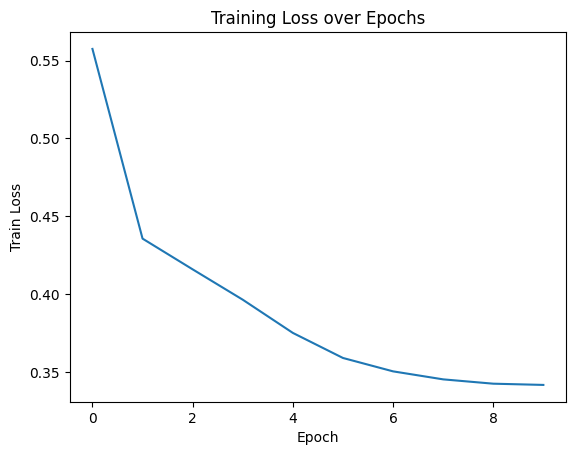

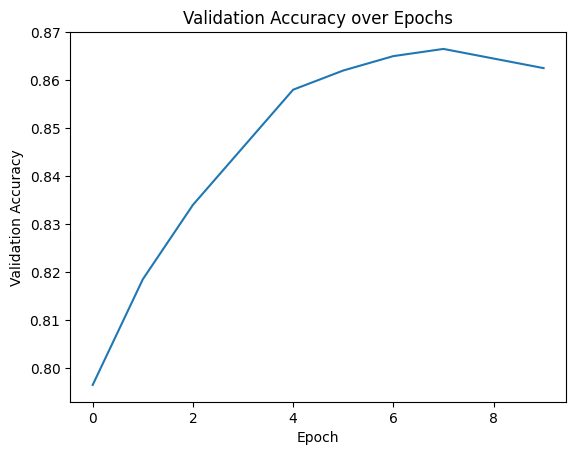

In [39]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()

## Answer

1. What validation accuracy did you reach?
2. Does the model appear to overfit or underfit?
3. Name one way to potentially improve performance (architecture or preprocessing).


In [50]:
## Answers
# 1. I got 0.8625 val accuracy.
# 2. The model is well trained and it does not show any big signs of underfitting or overfitting.
# 3. If we add dropout layers and maybe with change of the learning rate.

## Run the tests to verify your solution

In [40]:
import hashlib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def hash_data_frame(df: pd.DataFrame) -> str:
    """
    Compute a stable hash for a DataFrame by:
    - sorting columns
    - sorting rows by all columns
    - hashing the underlying values
    """
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

def hash_series(series: pd.Series) -> str:
    """
    Compute a stable hash for a Series by:
    - converting values to string
    - joining with commas
    - hashing the resulting string
    """
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

def check_signature(expected: str, actual: str):
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

def test_prepare_data(func, sig_X_train, sig_X_val, sig_y_train, sig_y_val):
    """
    Wrapper for testing the student's `prepare_data(df)` function using hashes.
    """
    df = pd.read_csv("churn.csv")
    X_train, X_val, y_train, y_val, preprocessor, scaler = func(df)

    # Convert to DataFrame / Series for hashing
    X_train_df = pd.DataFrame(X_train)
    X_val_df = pd.DataFrame(X_val)
    y_train_s = pd.Series(y_train).reset_index(drop=True)
    y_val_s = pd.Series(y_val).reset_index(drop=True)

    # Basic sanity
    assert X_train_df.shape[0] > 0
    assert X_val_df.shape[0] > 0
    assert X_train_df.shape[1] == X_val_df.shape[1]

    # Hashes
    h_Xtr = hash_data_frame(X_train_df)
    h_Xv  = hash_data_frame(X_val_df)
    h_ytr = hash_series(y_train_s)
    h_yv  = hash_series(y_val_s)

    try:
        assert h_Xtr == sig_X_train
        assert h_Xv  == sig_X_val
        assert h_ytr == sig_y_train
        assert h_yv  == sig_y_val
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed (signatures do not match).")
        # Uncomment while generating signatures:
        # print("DEBUG:", h_Xtr, h_Xv, h_ytr, h_yv)
        raise

In [41]:
### TEST
SIG_X_TRAIN = "5c50238ec85cb41c11b0eabc4be851c56a41aa367bc3945dcfc07e83a5e8e079"
SIG_X_VAL   = "4ef850e8dea3a9f462535f178165dc02b06a1f5e31ac9d364d779b291407d33a"
SIG_Y_TRAIN = "9b8c6fff66645ef6ca27fb516a51c4c9d2645710f2809c05887d98fa938e93e4"
SIG_Y_VAL   = "516080ad1fc8e2349df09a1de08ffb3fc50d7ff7a36c5f4f82af08b8ef55f783"

test_prepare_data(
    prepare_data,
    SIG_X_TRAIN,
    SIG_X_VAL,
    SIG_Y_TRAIN,
    SIG_Y_VAL
)


✔ Test passed!


In [42]:
### TEST 
train_ds = ChurnDataset(X_train, y_train)

# basic length
assert len(train_ds) == X_train.shape[0]

# sample item
x0, y0 = train_ds[0]
assert isinstance(x0, torch.Tensor)
assert isinstance(y0, torch.Tensor)
assert x0.shape[0] == X_train.shape[1]
assert y0.shape == (1,)
assert x0.dtype == torch.float32
assert y0.dtype == torch.float32

print("✔ Test passed!")


✔ Test passed!


In [43]:
### TEST 
input_dim = X_train.shape[1]
model_test = build_model(input_dim)

assert isinstance(model_test, torch.nn.Module)

dummy = torch.randn(4, input_dim)
out = model_test(dummy)

# output shape and range
assert out.shape == (4, 1)
assert torch.all(out >= 0.0)
assert torch.all(out <= 1.0)

print("✔ Test passed!")


✔ Test passed!


In [44]:
### TEST 
train_loader_test = DataLoader(ChurnDataset(X_train, y_train), batch_size=64, shuffle=True)

model_te = build_model(X_train.shape[1])
criterion_te = torch.nn.BCELoss()
optimizer_te = torch.optim.Adam(model_te.parameters(), lr=0.001)

loss1 = train_one_epoch(model_te, train_loader_test, criterion_te, optimizer_te)

assert isinstance(loss1, float)
assert 0.0 < loss1 < 10.0   # loose bounds

print("✔ Test passed!")


✔ Test passed!


In [45]:
### TEST 
val_loader_test = DataLoader(ChurnDataset(X_val, y_val), batch_size=256, shuffle=False)

acc_val = evaluate(model_te, val_loader_test)

assert isinstance(acc_val, float)
assert 0.0 <= acc_val <= 1.0

print("✔ Test passed!")


✔ Test passed!
